In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew,boxcox_normmax, zscore
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses, metrics, callbacks, regularizers

In [3]:
df = pd.read_csv("/content/drive/MyDrive/MAI391/HistoricalQuotes.csv")
df

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23
...,...,...,...,...,...,...
2513,03/05/2010,$31.2786,224647427,$30.7057,$31.3857,$30.6614
2514,03/04/2010,$30.1014,89591907,$29.8971,$30.1314,$29.8043
2515,03/03/2010,$29.9043,92846488,$29.8486,$29.9814,$29.7057
2516,03/02/2010,$29.8357,141486282,$29.99,$30.1186,$29.6771


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [5]:
df.isnull().sum().sort_values(ascending=False)

Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2518 non-null   datetime64[ns]
 1    Close/Last  2518 non-null   object        
 2    Volume      2518 non-null   int64         
 3    Open        2518 non-null   object        
 4    High        2518 non-null   object        
 5    Low         2518 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 118.2+ KB


In [8]:
df.rename(columns={" Close/Last": "Close/Last"}, inplace=True)
df["Close/Last"] = df["Close/Last"].str.replace("$", "").astype(float)

<ipython-input-8-6a14270f72ab>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Close/Last"] = df["Close/Last"].str.replace("$", "").astype(float)


In [12]:
df.rename(columns={" Open": "Open"}, inplace=True)
df.rename(columns={" High": "High"}, inplace=True)
df.rename(columns={" Low": "Low"}, inplace=True)
df.rename(columns={" Volume": "Volume"}, inplace=True)

df["Open"] = df["Open"].str.replace("$", "").astype(float)
df["High"] = df["High"].str.replace("$", "").astype(float)
df["Low"] = df["Low"].str.replace("$", "").astype(float)

<ipython-input-12-c6dec5c3f3f6>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Open"] = df["Open"].str.replace("$", "").astype(float)
<ipython-input-12-c6dec5c3f3f6>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["High"] = df["High"].str.replace("$", "").astype(float)
<ipython-input-12-c6dec5c3f3f6>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Low"] = df["Low"].str.replace("$", "").astype(float)


In [11]:
df.columns

Index(['Date', 'Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')

In [13]:
data = df[["Close/Last"]]
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [16]:
test_len = 60
train_len = data.shape[0]-test_len
timesteps = 60
features  = 1

X_train = []
y_train = []

for i in range(timesteps, train_len):
  X_train.append(data[i-timesteps:i, :])
  y_train.append(data[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

(2398, 60, 1) (2398, 1)


In [17]:
model = Sequential()

model.add(LSTM(60, return_sequences=True, input_shape=(timesteps, features)))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(30))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(X_train, y_train, batch_size=10, epochs=2)

Epoch 1/2
240/240 [==============================] - 18s 56ms/step - loss: 0.0018
Epoch 2/2
240/240 [==============================] - 14s 58ms/step - loss: 2.3645e-04


In [19]:
X_test = []
y_test = []

for i in range(train_len, data.shape[0]):
  X_test.append(data[i-timesteps:i, :])
  y_test.append(data[i, :])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [20]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

2/2 [==============================] - 2s 21ms/step


In [21]:
rmse = np.sqrt(((y_test - y_pred)**2).mean())
rmse

3.507750505934688

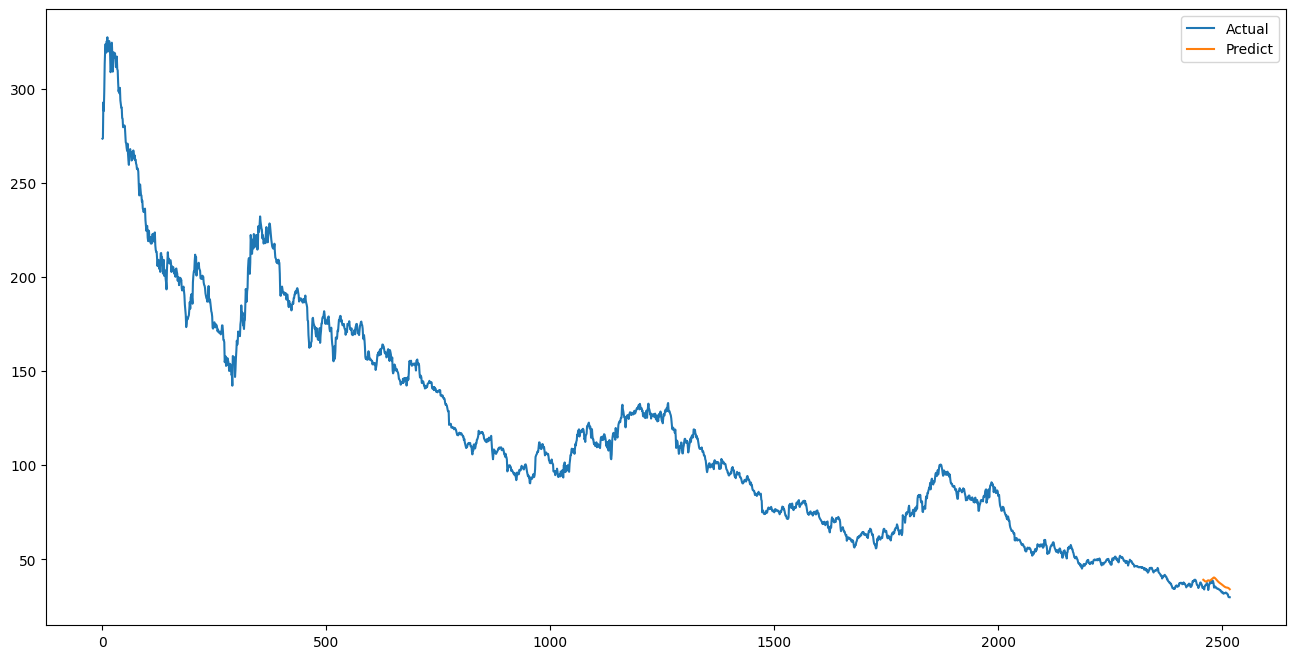

In [22]:
actual = df[['Close/Last']]
pred   = df[['Close/Last']].iloc[train_len:, :]
pred[['Predict']] = y_pred
plt.figure(figsize=(16, 8))
plt.plot(actual, label='Actual')
plt.plot(pred[['Predict']], label='Predict')
plt.legend()
plt.show()